This notebook will be used to compare the tidal ellipses from the model outputs to the ones generated by Mike Foreman's model in Foreman et al. (2004).

In [2]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd

import netCDF4 as nc
from scipy.optimize import curve_fit
import scipy.io as sio
from salishsea_tools import (viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

In [18]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

##Loading Data
7 months of data takes a long time to compile therefore the paramters have been saved into files in this [notebook](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/SaveTidalParameters.ipynb). In the cells below we will load the ellipse parameters into a matrix with all the M2 and K1 parameters at Haro Strait, Juan de Fuca West and Eastm Johnstone Strait and at Arran Rapids.

In [127]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 24)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

loc = ['JuanW', 'JuanE', 'Haro', 'JS']
count = np.arange(0,5)
params = np.zeros((4,39,5))
params_av = np.zeros((4,8))
cols=np.arange(0,5)

for i,j in zip(loc,count):
    runname1 = '{}_{}_{}'.format(t_o, t_f, i)
    runname2 = '{}_{}_{}_depav(20-200)'.format(t_o, t_f, i)
    df1 = pd.read_csv(runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv(runname2+'.csv', index_col=False)
    params[j,:,:] = df1.as_matrix()
    params_av[j,:] = df2.as_matrix()


In [131]:
print params_av.shape

(4, 8)


##The Foreman Locations

In [43]:
#Haro Strait
iH = 233
jH = 312

#Juan de Fuca West
iJW=8
jJW=408

#Juan de Fuca East
iJE = 151
jJE = 275

#Johnstone Strait
iJS = 58
jJS = 885

(898, 398)
red is clockwise


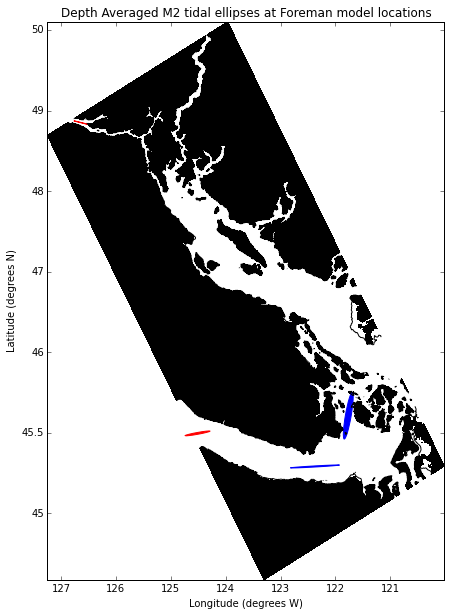

In [44]:
phi=29
fig = plt.figure(figsize=(10,10))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 2

imin=3
imax = 333

jmin = 176
jmax = 895

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
scale = 100
dep=10

#Making the ellipse for the Central node

count = np.arange(0,4)
i = (iJW, iJE, iH, iJS)
j = (jJW, jJE, jH, jJS)

for loc, i, j in zip(count, i ,j):
    if params_av[loc,1] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[j,i],k[j,i]), width=scale*params_av[loc,0], 
                        height=scale*params_av[loc,1], angle=params_av[loc,2],
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude
#ax.set_ylim(300,350)
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(44, 50, 0.5)-
                           lats[jmin,imin])/slope).tolist()
labels = ['44.5','45','45.5','46','47','48', '49','50']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
#ax.set_xlim(100,120)
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-127,-120.5,1)-
                        lons[jmin,imin])/slope).tolist()
labels = ['127','126','125','124','123','122','121', '120']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')
print bathy.data.shape

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at Foreman model locations')

print "red is clockwise"

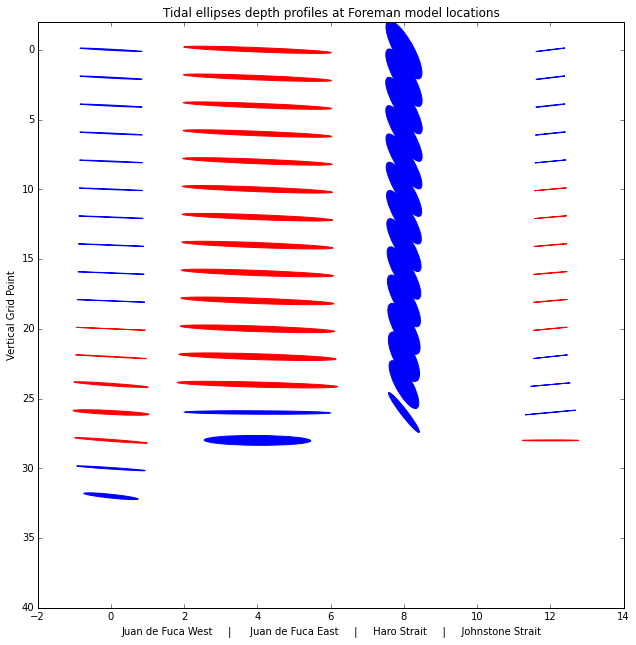

In [92]:
fig = plt.figure(figsize=(10.5,10.5))
ax = fig.add_subplot(111)
scale = 5
interval = 2

for loc in np.arange(0,4):
    for dep in np.arange(0,40,interval):
        if params[loc,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(loc*4,dep), width=scale*params[loc,dep,1], 
                            height=scale*params[loc,dep,2], angle=params[loc,dep,3],
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)

ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,14)
ax.set_title('Tidal ellipses depth profiles at Foreman model locations')
ax.set_ylabel('Vertical Grid Point')
ax.set_xlabel('Juan de Fuca West     |      Juan de Fuca East     |     Haro Strait     |     Johnstone Strait ')

##Load Foreman Model Values
The u and v velocities were calculated from Mike Foreman's model using MATLAB code written by Richard Dewey.
I used the same period of time as for the model output parameters, but these value have one u and v for each day, the Salish Sea MEOPAR model uses hourly data.

In [20]:
u = sio.loadmat('/ocean/mdunn/Tides/u_foreman.mat')['u']
v = sio.loadmat('/ocean/mdunn/Tides/v_foreman.mat')['v']
time1 = 735929
time2 = 736139+1

time = np.arange(0,time2-time1)
params_f = np.zeros((4,4))
for i in np.arange(0,4):
    uM2amp, uM2pha, uK1amp, uK1pha = tidetools.fittit(u[i], time)
    vM2amp, vM2pha, vK1amp, vK1pha = tidetools.fittit(v[i], time)
    CX, SX, CY, SY, ap, am, ep, em, major, minor, theta, phase = tidetools.ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha)
    CX_k, SX_k, CY_k, SY_k, ap_k, am_k, ep_k, em_k, major_k, minor_k, theta_k, phase_k = tidetools.ellipse_params (uK1amp, uK1pha, vK1amp, vK1pha)
    params_f[i,:] = [major/10, minor/10, theta, phase]

In [152]:
param_mat = sio.loadmat('/ocean/mdunn/Tides/param_foreman.mat')['params']

loc = ['Juan de Fuca West','Juan de Fuca East','Haro Strait','Johnstone Strait ']
k = np.arange(0,4)
param_mat[:,0:2] = param_mat[:,0:2]/100

obs_amp = [0.389, 0.735, 0.513, 0.381]
obs_pha = [294, 304, 312, 88]

    Foreman Model (fittit) column: I used Richard Dewey's vitide.m function that calculates the u and v velocity time series for a chosen date range from the tidal ellipses parameters at a given location. Then fit the velocities using the fittit function and calculate the ellipse parameters from this.(This is redundant)

    Foreman Model: Modified Dewey's code to output the tidal ellipse parameters of the given locations directly.

In [134]:
print "                            Foreman Model(fittit)      |             Foreman Model              |   Obs"
print "                  Major-Axis   Minor-Axis     Angle    |   Major-Axis   Minor-Axis     Angle    |  Amp"
print "                     (m/s)       (m/s)     (deg ccw E) |      (m/s)       (m/s)     (deg ccw E) |  m/s" 

for name, i in zip(loc, k):
    print '%-20s {0:.2f}      {1:.2f}        {2:.0f}                 {3:.2f}         {4:.2f}        {5:.0f}         {6:.2f}'.format( 
              params_f[i,0], params_f[i,1], params_f[i,2], param_mat[i,0], param_mat[i,1], param_mat[i,2], obs_amp[i]) %name

                            Foreman Model(fittit)      |             Foreman Model              |   Obs
                  Major-Axis   Minor-Axis     Angle    |   Major-Axis   Minor-Axis     Angle    |  Amp
                     (m/s)       (m/s)     (deg ccw E) |      (m/s)       (m/s)     (deg ccw E) |  m/s
Juan de Fuca West    0.47      0.01        1                 0.51         -0.00        74         0.39
Juan de Fuca East    0.87      -0.03        2                 0.93         0.01        3         0.73
Haro Strait          0.68      0.10        106                 0.69         -0.06        97         0.51
Johnstone Strait     0.72      0.10        153                 0.78         -0.09        154         0.38


##Comparison with a table
Using the depth averaged (20-200m) of the Salish Sea MEOPAR model to compare with Foremans Model's parameters calculated two different ways

In [168]:
loc = ['Juan de Fuca West','Juan de Fuca East','Haro Strait','Johnstone Strait ']
k = np.arange(0,4)
foreman2004 = [50.2/100, 93.2/100, 60.1/100, 65.2/100]

In [169]:
print "                                Salish Sea Model         |      Foreman et al.(2004)                "
print "                   Major-Axis   Minor-Axis     Angle     |    Amplitude  "
print "                     (m/s)       (m/s)       (deg ccw E) |      (m/s)  " 

for name, i in zip(loc, k):
    print '%-20s {0:.2f}        {1:.2f}           {2:.0f}            {3:.2f}  '.format( 
              params_av[i,0], params_av[i,1], params_av[i,2], foreman2004[i]) %name


                                Salish Sea Model         |      Foreman et al.(2004)                
                   Major-Axis   Minor-Axis     Angle     |    Amplitude  
                     (m/s)       (m/s)       (deg ccw E) |      (m/s)  
Juan de Fuca West    0.40        -0.03           9            0.50  
Juan de Fuca East    0.79        0.02           3            0.93  
Haro Strait          0.68        0.09           79            0.60  
Johnstone Strait     0.25        -0.00           168            0.65  


The Salish Sea MEOPAR Model is closest to the observations reported in Foreman et al. (2004)!

##Graph Comparison

In [157]:

count = np.arange(0,4)
parameter = ['major-axis', 'minor-axis', 'inclination']
unit = ['m/s','m/s','deg']

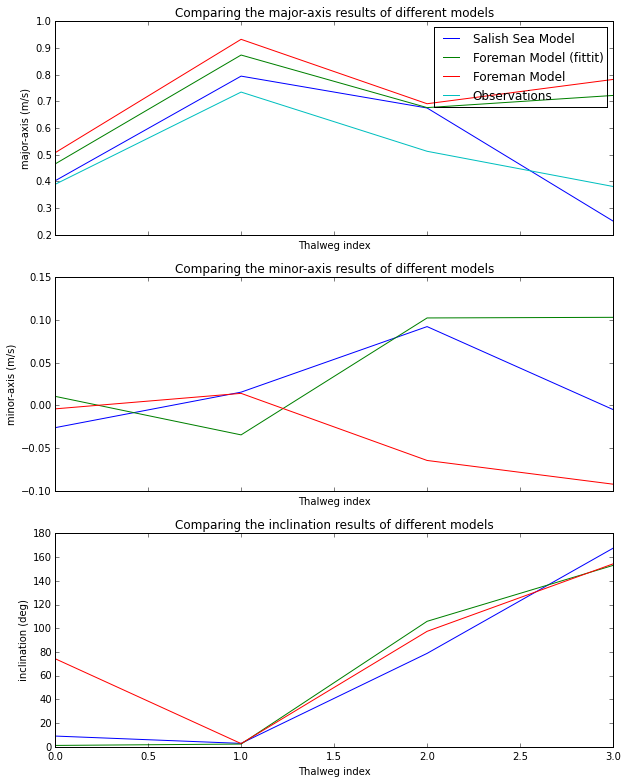

In [170]:
fig, (ax0, ax1, ax2)= plt.subplots(3,1,figsize=(10,13), sharex=True)

for ax , k, par, u in zip([ax0, ax1, ax2], np.arange(0,3), parameter, unit):
    ax.plot(count[:],params_av[:,k], '-', label='Salish Sea Model')
    ax.plot(count[:], params_f[:,k], '-', label='Foreman Model (fittit)')
    ax.plot(count[:], param_mat[:,k], '-', label='Foreman Model')
    if ax == ax0:
        ax.plot(count[:], obs_amp[:], '-',label='Observations')

    ax.set_title('Comparing the {} results of different models'.format(par))
    ax.set_xlabel('Thalweg index')
    ax.set_ylabel('{} ({})'.format(par,u))
ax0.legend()

##Map comparison

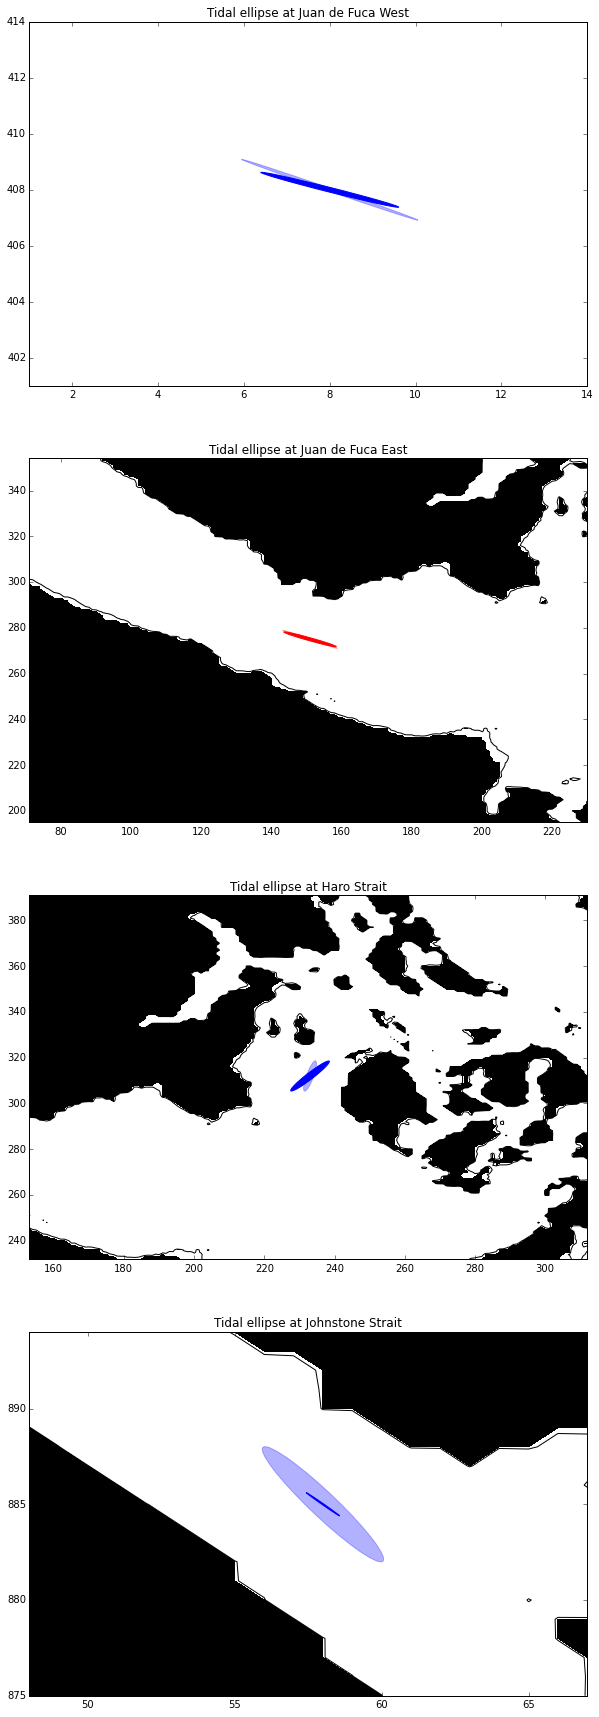

In [99]:
phi=0
fig, ax = plt.subplots(4 , 1, figsize=(10,30))
k = np.zeros((898,398))
m = np.zeros((898,398))


count = np.arange(0,4)
name = ['Juan de Fuca West','Juan de Fuca East', 'Haro Strait', 'Johnstone Strait']
iss = [iJW, iJE, iH, iJS]
jss = [jJW, jJE, jH, jJS]
for a, b ,c,n in zip(iss, jss, count,name): 
    if b > 850:
        ex = 10
        scale = 10
    elif a < 10:
        ex = 7
        scale = 10
    else:
        ex = 80
        scale = 20
    
    imin = a
    imax = a

    jmin = b
    jmax = b

    for q in np.arange(jmin-ex,jmax+ex):
        for l in np.arange(imin-ex,imax+ex):
            k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
            m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
    

    #Making the ellipse Salish Sea Model
    if params[c,0,2] > 0:
         thec = 'b' 
    else:
        thec = 'r'
    ellsc1 = Ellipse(xy=(m[b,a],k[b,a]), width=scale*params[c,0,1], 
                            height=scale*params[c,0,2], angle=params[c,0,3]-29,
                            color=thec)
    ax[c].add_artist(ellsc1)
    ellsc1.set_facecolor(thec)

    #Making the ellipse Foreman model
    if params_f[c,1] > 0:
        thec = [0,0,1, 0.3]
    else:
        thec = [1,0,0, 0.3]
    ellsc = Ellipse(xy=(m[b,a],k[b,a]), width=scale*params_f[c,0], 
                            height=scale*params_f[c,1], angle=params_f[c,2]-29,
                            color=thec)
    ax[c].add_artist(ellsc)
    ellsc.set_facecolor(thec)
    # land, and 5 m contour
    contour_interval = [-0.01, 0.01]
    ax[c].contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
    ax[c].contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
                bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
    ax[c].set_title('Tidal ellipse at {}'.format(n))